In [2]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())

import numpy as np
import copy
import matplotlib.pyplot as plt

from src.solver_utils import solve_precond  # not used here but you may keep it imported
from src.basis.basis import BasisHandler
from src.matrix_generation import assemble_matrix_integral_1d, extend_mass, extend_stiffness
from src.primitives import Primitives_MinimalSupport
from src.operators import differentiate

In [3]:
def run_wave_2d_demo(J_max=4, J_0=2, T=1.0, cfl_safety=0.2, plot=True):
    """
    Minimal 2D wave equation demo on the unit square using the existing framework.
    u_tt = Δ u, u(.,.,0) = sin(pi x) sin(pi y), u_t(.,.,0)=0, f=0.

    Spatial: wavelet–Galerkin, 1D assembly + Kronecker extension.
    Time: central difference with mass lumping (diagonal), so each step is O(nnz(S2)).

    Parameters
    ----------
    J_max : int        Finest level for the basis.
    J_0   : int        Coarsest level (your framework uses 2 typically).
    T     : float      Final time.
    cfl_safety : float CFL safety factor; dt ≈ cfl_safety * 2^{-J_max}.
    plot  : bool       If True, plot final solution surface.

    Returns
    -------
    xs, ys : 1D grids used for visualization
    U_final : 2D array of u(x,y,T)
    """
    # ----- Build 1D basis & its derivative (for matrix assembly only) -----
    primitives = Primitives_MinimalSupport()
    bh = BasisHandler(primitives=primitives, dimension=1)
    bh.build_basis(J_Max=J_max, J_0=J_0, comp_call=True)

    bh_d = copy.deepcopy(bh)
    bh_d.apply(differentiate, comp_call=True, axis=0)

    # ----- Assemble 1D matrices and extend to 2D -----
    M1 = assemble_matrix_integral_1d(bh.flatten(),  bh.flatten())
    S1 = assemble_matrix_integral_1d(bh_d.flatten(), bh_d.flatten())

    M2 = extend_mass(M1, 2)
    S2 = extend_stiffness(M1, S1, 2)
    N = M2.shape[0]
    print(f"[info] 2D size N = {N}, nnz approx (dense count) = {np.count_nonzero(S2)}")

    # ----- Lumped mass (diagonal) for explicit stepping -----
    # Standard FE lumping: diagonal entries are the row sums of M2
    m_lumped = M2.sum(axis=1).astype(float).reshape(-1)  # shape (N,)
    inv_m = 1.0 / m_lumped

    # ----- Initial conditions in coefficient space (mass projection) -----
    u0 = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
    v0 = lambda x, y: 0.0 + 0.0 * x  # vectorized zero

    # Project to coefficient space via mass projection: M c ≈ b  => c ≈ M^{-1}_lumped b
    b_u0 = bh.project_rhs_2d_gauss(u0)     # length N
    c0 = b_u0 * inv_m                      # lumped solve

    b_v0 = bh.project_rhs_2d_gauss(v0)
    v0_coeff = b_v0 * inv_m

    # ----- Time step (CFL-ish choice): dt ~ cfl_safety * 2^{-J_max} -----
    dt = cfl_safety * (2.0 ** (-J_max))
    Nt = int(np.ceil(T / dt))
    dt = T / Nt  # align to T exactly
    print(f"[info] dt = {dt:.4e}, Nt = {Nt}")

    # Kickoff (central difference start):
    # c1 = c0 + dt*v0 + 0.5*dt^2 * inv_m * (Δ u0) = c0 + dt*v0_coeff - 0.5*dt^2 * (inv_m * (S2 @ c0))
    c1 = c0 + dt * v0_coeff - 0.5 * (dt ** 2) * (inv_m * (S2 @ c0))

    # ----- Main time loop (explicit, lumped) -----
    cn_minus = c0
    cn = c1
    for n in range(1, Nt):
        # c_{n+1} = 2 c_n - c_{n-1} + dt^2 * inv_m * (Δ u_n) = 2 c_n - c_{n-1} - dt^2 * (inv_m * (S2 @ c_n))
        lap_cn = S2 @ cn
        cn_plus = 2.0 * cn - cn_minus - (dt ** 2) * (inv_m * lap_cn)

        cn_minus, cn = cn, cn_plus

    coeffs_final = cn

    # ----- Evaluate on a visualization grid -----
    xs = np.linspace(0, 1, 120)
    ys = np.linspace(0, 1, 120)
    U_final = bh.evaluate_solution_2d_kron(coeffs_final, xs, ys)

    if plot:
        X, Y = np.meshgrid(xs, ys, indexing="ij")
        fig = plt.figure(figsize=(7, 5))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot_surface(X, Y, U_final, linewidth=0, antialiased=True, cmap="viridis")
        ax.set_title(f"2D Wave @ T={T:.2f}, J_max={J_max}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("u(x,y,T)")
        plt.tight_layout()
        plt.show()

    return xs, ys, U_final

/Users/rados/Projects_personal/Galerkin_solver3/src/matrix_generation.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, _ = quad(lambda x: fi(x) * fj(x), a, b, epsabs=1e-12, epsrel=1e-12)


[info] 2D size N = 1024, nnz approx (dense count) = 204160
5
5
[info] dt = 1.2500e-02, Nt = 80


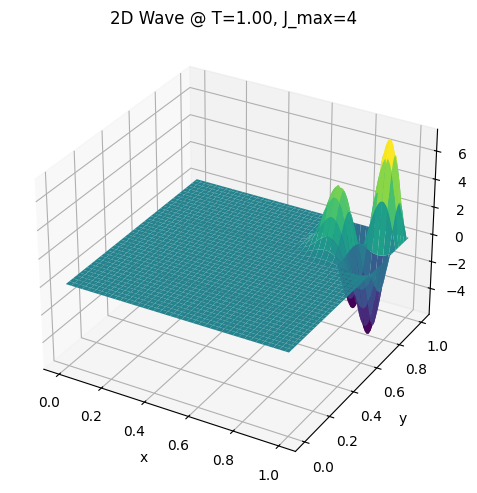

In [4]:
xs, ys, U = run_wave_2d_demo(J_max=4, T=1.0, cfl_safety=0.2, plot=True)

In [38]:
def assemble_wave_matrices_2d(J_max=4, J_0=2):
    """
    Assemble 2D mass (M2) and stiffness (S2) matrices
    using the tensor-product of 1D Galerkin matrices.
    """

    primitives = Primitives_MinimalSupport()
    bh = BasisHandler(primitives=primitives, dimension=1)
    bh.build_basis(J_Max=J_max, J_0=J_0, comp_call=True)

    bh_d = copy.deepcopy(bh)
    bh_d.apply(differentiate, comp_call=True, axis=0)

    # 1D matrices
    M1 = assemble_matrix_integral_1d(bh.flatten(), bh.flatten())
    S1 = assemble_matrix_integral_1d(bh_d.flatten(), bh_d.flatten())

    # Extend to 2D
    M2 = extend_mass(M1, 2)
    S2 = extend_stiffness(M1, S1, 2)
    return M2, S2, bh
    
def solve_wave_2d_newmark(
    u0, v0, M2, S2, bh,
    T=1.0, dt=5e-3,
    beta=1/4, gamma=1/2,
    save_every=10
):
    """
    Solve 2D wave equation u_tt = Δu using Newmark-β scheme (β=1/4, γ=1/2).
    Unconditionally stable and second-order accurate.

    Parameters
    ----------
    u0, v0 : callable
        Initial displacement and velocity, functions of (x,y).
    M2, S2 : np.ndarray
        Mass and stiffness matrices.
    bh : BasisHandler
        Basis handler (1D) for projection/evaluation.
    T : float
        Final time.
    dt : float
        Time step.
    beta, gamma : float
        Newmark parameters (default: implicit trapezoidal rule).
    save_every : int
        Save every N-th time step.

    Returns
    -------
    coeff_hist : np.ndarray
        Coefficient snapshots over time (shape: n_saved × N).
    times : np.ndarray
        Saved time points.
    """
    import numpy as np
    from src.solver_utils import solve_precond

    # --- Project initial conditions with consistent mass ---
    b_u0 = bh.project_rhs_2d_gauss(u0)
    b_v0 = bh.project_rhs_2d_gauss(v0)
    c0 = solve_precond(M2, b_u0)
    v0c = solve_precond(M2, b_v0)

    # --- Setup ---
    N = len(c0)
    Nt = int(np.ceil(T / dt))
    times = np.linspace(0, T, Nt + 1)
    inv_coeff = 1.0 / (beta * dt**2)

    # Effective stiffness matrix
    K_eff = S2 + inv_coeff * M2

    # Initial acceleration a0 = M^{-1}( -S u0 )
    a0 = solve_precond(M2, -S2 @ c0)

    # State variables
    u = c0.copy()
    v = v0c.copy()
    a = a0.copy()

    coeff_hist = [u.copy()]
    for n in range(1, Nt + 1):
        t = n * dt

        # Predictor
        u_pred = u + dt * v + 0.5 * dt**2 * (1 - 2 * beta) * a
        v_pred = v + dt * (1 - gamma) * a

        # RHS for u_{n+1}: M*(inv_coeff*u_pred) - S*u_pred (f=0)
        rhs = inv_coeff * (M2 @ u_pred)

        # Solve for u_next
        u_next = solve_precond(K_eff, rhs)

        # Update acceleration and velocity
        a_next = inv_coeff * (u_next - u_pred)
        v_next = v_pred + gamma * dt * a_next

        # Advance
        u, v, a = u_next, v_next, a_next

        if n % save_every == 0 or n == Nt:
            coeff_hist.append(u.copy())

    return np.array(coeff_hist), times

4
4
[result] L2 error at T=1.0 = 1.029e-04


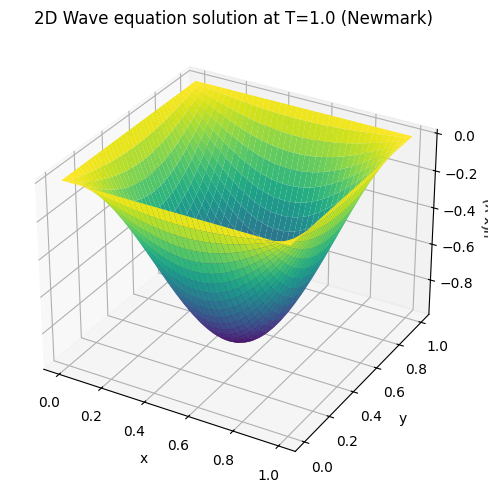

In [42]:
# --- Problem setup ---
u0 = lambda x, y: np.sin(np.pi * x) * np.sin(np.pi * y)
v0 = lambda x, y: 0.0 * x
u_exact = lambda x, y, t: np.sin(np.pi * x) * np.sin(np.pi * y) * np.cos(np.sqrt(2)*np.pi*t)

# --- Assemble matrices ---
M2, S2, bh = assemble_wave_matrices_2d(J_max=3, J_0=2)

# --- Solve with Newmark ---
coeff_hist, times = solve_wave_2d_newmark(u0, v0, M2, S2, bh, T=5.0, dt=5e-3, save_every=20)

# --- Evaluate final snapshot ---
coeff_final = coeff_hist[-1]
xs = np.linspace(0, 1, 120)
ys = np.linspace(0, 1, 120)
U_num = bh.evaluate_solution_2d_kron(coeff_final, xs, ys)

# --- Exact solution and L2 error ---
X, Y = np.meshgrid(xs, ys, indexing="ij")
U_ex = u_exact(X, Y, t=5.0)
err_L2 = np.sqrt(np.trapezoid(np.trapezoid((U_num - U_ex)**2, ys, axis=1), xs))
print(f"[result] L2 error at T=1.0 = {err_L2:.3e}")

# --- Plot ---
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, U_num, cmap="viridis", linewidth=0, antialiased=True)
ax.set_title("2D Wave equation solution at T=1.0 (Newmark)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
plt.tight_layout()
plt.show()